# This is to generate a random combination of serveral parameters within certain range + Latin Hypercube method

In [2]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2
import csv, random, os
import pybamm as pb;import pandas as pd;import numpy as np;
import os, json,openpyxl,traceback,multiprocessing,scipy.optimize
import matplotlib.pyplot as plt;
import imageio,timeit,random,time, signal
from scipy.io import savemat,loadmat;
from pybamm import constants,exp;import matplotlib as mpl; 
fs=17; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
# def functions
def save_rows_to_csv(file_path, rows, header):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)  # Write parameter names as the header row
        writer.writerows(rows)
def generate_combinations(Bounds, Num_tot):
    lower_bounds = []
    upper_bounds = []
    for bound in Bounds:
        lower_bounds.append(bound[0])
        upper_bounds.append(bound[1])
    combinations = []
    for _ in range(Num_tot):
        combination = []
        for lower, upper in zip(lower_bounds, upper_bounds):
            value = random.uniform(lower, upper)
            combination.append(value)
        combinations.append(combination)
    return combinations

def save_combinations_to_csv(combinations, parameter_names, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(parameter_names)  # Write parameter names as the first row
        for combination in combinations:
            writer.writerow(combination)

In [4]:
BasicPath =  os.path.expanduser("~/PyBaMM/docs/source/examples/notebooks/models/Pressure_wip/Ruihe")
Target  = f'/Get_Random_sets/'
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)

In [9]:
# generate cases for Xinlei, assume 
from pyDOE import lhs
# Keep dry-out ratio=1; discard stress-driven LAM_Pe
num = 1; 
cands_Dint = ( # IDEAL: 3.87E-19; 
    np.exp(np.linspace(np.log(2.5e-22), np.log(1e-21), num=num))).tolist()
# cands_Decay = (
#     np.exp(np.linspace(np.log(1e-10), np.log(1e-6), num=num))).tolist()
# cands_kLiP = (
#     np.exp(np.linspace(np.log(1e-12), np.log(1e-9), num=num))).tolist()
#cands_V_SEI = (
#    np.linspace(8.05e-5, 14e-5, num=num)).tolist()
#cands_Eact_SEI = (
#    np.linspace(1e4, 4e4, num=num)).tolist()
#cands_h = (
#    np.linspace(15, 40, num=num)).tolist()
parameter_names = [
    "Scan No",
    "Exp No.",
    "Ageing temperature",
    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]', 
    # 'Dead lithium decay constant [s-1]',
    # 'Lithium plating kinetic rate constant [m.s-1]',
    # 'Outer SEI partial molar volume [m3.mol-1]', 
    # 'SEI growth activation energy [J.mol-1]',
    # 'Total heat transfer coefficient [W.m-2.K-1]',
]
# Combine the candidate lists
# candidate_lists = [
#     cands_Dint, cands_Decay, cands_kLiP, 
#     cands_V_SEI, cands_Eact_SEI,cands_h]
candidate_lists = [
    cands_Dint]
# Generate Latin hypercube samples
samples = lhs(len(candidate_lists), samples=num)
# Initialize the parameter combinations list
combinations = []
Exps  = [10,]
Temps = [25,]

para_dict_Same = {
   "Cycles within RPT":1,
   "RPT temperature":25,
   "Mesh list":[5,5,5,30,30],   # Simon uses 30
   "Para_Set": "OKane2023_Xinlei", # Li2023_Coupled
   "Model option":{
        #"contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "lithium plating": "partially reversible",
        "lithium plating porosity change": "true",  # alias for "SEI porosity change"
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "loss of active material": "stress-driven",
        "calculate discharge energy": "true",},  # for compatibility with older PyBaMM versions
    "Negative electrode LAM constant proportional term [s-1]": 2.7778e-07 * 3, #1e-16,  
    "Positive electrode LAM constant proportional term [s-1]": 2.7778e-07 * 20, #1e-16,
    "Current solvent concentration in the reservoir [mol.m-3]":4541.0,
    "Current electrolyte concentration in the reservoir [mol.m-3]":1000,
    "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":1.0,
    'EC initial concentration in electrolyte [mol.m-3]':4541.0,
    'Typical EC concentration in electrolyte [mol.m-3]':4541.0, 
    # unchange now:
    'Initial electrolyte excessive amount ratio':1.2, 
    "Ratio of lithium moles to SEI moles":1.0,
    #"Contact resistance [Ohm]": 0.012,
    # Xinlei added 
    "Negative electrode critical stress [Pa]": 6e8, # reduce LLI_LAM
    "Positive electrode critical stress [Pa]": 2e9, # reduce LLI_LAM
    "Initial concentration in negative electrode [mol.m-3]": 28600, # previous 28800
    "Initial concentration in positive electrode [mol.m-3]": 13100, # previous 12729
}
unchange_key2 = list(para_dict_Same.keys())
unchange_val2 = list(para_dict_Same.values())
# Create the parameter combinations
count = 0
for Exp in Exps:
    for Temp in Temps:
        for sample in samples:
            count += 1      # "Scan No"
            combination = [count,Exp,Temp,]
            for i, candidate_list in enumerate(candidate_lists):
                index = int(sample[i] * num)
                combination.append(candidate_list[index])
            combination = [*combination,*unchange_val2]
            combinations.append(combination)
parameter_names = [*parameter_names,*unchange_key2]
Target_name = "Warwick_ageing"
filename = BasicPath+"/Get_Random_sets/"+f'{Target_name}.csv'
save_combinations_to_csv(combinations, parameter_names, filename)
print(f"Combinations saved to '{Target_name}.csv' file.") 

Combinations saved to 'Warwick_ageing.csv' file.


In [26]:
import itertools
cands_Dint  = [3e-20, 3e-19, 3e-18]
cands_Decay = [1e-13, 1e-9,  1e-6]
cands_kLiP  = [1e-14, 1e-11, 1e-8]
cands_LAM_Nep = [1e-9,]
cands_V_SEI = [6.4e-5, 13e-5]


combinations = [
    list(comb) for comb in itertools.product(
        cands_Dint, cands_Decay, cands_kLiP, cands_LAM_Nep, cands_V_SEI)]

print(combinations)

[[3e-20, 1e-13, 1e-14, 1e-09, 6.4e-05], [3e-20, 1e-13, 1e-14, 1e-09, 0.00013], [3e-20, 1e-13, 1e-11, 1e-09, 6.4e-05], [3e-20, 1e-13, 1e-11, 1e-09, 0.00013], [3e-20, 1e-13, 1e-08, 1e-09, 6.4e-05], [3e-20, 1e-13, 1e-08, 1e-09, 0.00013], [3e-20, 1e-09, 1e-14, 1e-09, 6.4e-05], [3e-20, 1e-09, 1e-14, 1e-09, 0.00013], [3e-20, 1e-09, 1e-11, 1e-09, 6.4e-05], [3e-20, 1e-09, 1e-11, 1e-09, 0.00013], [3e-20, 1e-09, 1e-08, 1e-09, 6.4e-05], [3e-20, 1e-09, 1e-08, 1e-09, 0.00013], [3e-20, 1e-06, 1e-14, 1e-09, 6.4e-05], [3e-20, 1e-06, 1e-14, 1e-09, 0.00013], [3e-20, 1e-06, 1e-11, 1e-09, 6.4e-05], [3e-20, 1e-06, 1e-11, 1e-09, 0.00013], [3e-20, 1e-06, 1e-08, 1e-09, 6.4e-05], [3e-20, 1e-06, 1e-08, 1e-09, 0.00013], [3e-19, 1e-13, 1e-14, 1e-09, 6.4e-05], [3e-19, 1e-13, 1e-14, 1e-09, 0.00013], [3e-19, 1e-13, 1e-11, 1e-09, 6.4e-05], [3e-19, 1e-13, 1e-11, 1e-09, 0.00013], [3e-19, 1e-13, 1e-08, 1e-09, 6.4e-05], [3e-19, 1e-13, 1e-08, 1e-09, 0.00013], [3e-19, 1e-09, 1e-14, 1e-09, 6.4e-05], [3e-19, 1e-09, 1e-14, 1e

In [27]:
original_list = [[5, 6], [7, 8], [9, 10]]
appended_list = [[i+1,*elem, 1, 2, 3, 4] for i,elem in enumerate(original_list)]
print(appended_list)


[[1, 5, 6, 1, 2, 3, 4], [2, 7, 8, 1, 2, 3, 4], [3, 9, 10, 1, 2, 3, 4]]


In [28]:
# 10 cases for dry-out only - 2023-6-7
Target_name = "20cases_for_Dry_out"
candidates_Dint = [3.97e-19]
candidates_elely_res = [ 1.0]    # pick only 0.99 and 1.0
candidates_V_SEI  = (np.linspace(4e-05, 15e-05, num=20)).tolist()
Candidates = [
    candidates_Dint, candidates_elely_res,
    candidates_V_SEI]
parameter_names = [
    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]', 
    'Initial electrolyte excessive amount ratio', 
    'Outer SEI partial molar volume [m3.mol-1]', 
]
# Usage example:
combinations = []
for Dint in candidates_Dint:
    for elely_res in candidates_elely_res:
        for V_SEI in candidates_V_SEI:
            combinations.append([Dint,elely_res,V_SEI])
filename = BasicPath+Target+f'{Target_name}.csv'
save_combinations_to_csv(combinations, parameter_names, filename)
print(f"Combinations saved to '{Target_name}.csv' file.")

Combinations saved to '20cases_for_Dry_out.csv' file.


In [29]:
# Latin hypercube - 6 parameters, 200 cases, - 23-06-08 really big range for 
from pyDOE import lhs
# Keep dry-out ratio=1; discard stress-driven LAM_Pe
num = 200; 
cands_Dint = (
    np.exp(np.linspace(np.log(3e-22), np.log(3e-16), num=num))).tolist()
cands_Decay = (
    np.exp(np.linspace(np.log(4e-10), np.log(4e-4), num=num))).tolist()
cands_kLiP = (
    np.exp(np.linspace(np.log(1e-14), np.log(1e-6), num=num))).tolist()
cands_LAM_Nep = (
    np.exp(np.linspace(np.log(1e-12), np.log(3e-5), num=num))).tolist()
cands_k_Necr = (
    np.exp(np.linspace(np.log(1e-25), np.log(1e-16), num=num))).tolist()
cands_V_SEI = (
    np.linspace(4e-5, 15e-5, num=num)).tolist()
parameter_names = [
    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]', 
    'Dead lithium decay constant [s-1]',
    'Lithium plating kinetic rate constant [m.s-1]',
    'Negative electrode LAM constant proportional term [s-1]',
    'Negative electrode cracking rate',
    'Outer SEI partial molar volume [m3.mol-1]', ]
# Combine the candidate lists
candidate_lists = [
    cands_Dint, cands_Decay, cands_kLiP, 
    cands_LAM_Nep, cands_k_Necr, cands_V_SEI]

# Generate Latin hypercube samples
samples = lhs(len(candidate_lists), samples=num)

# Initialize the parameter combinations list
combinations = []

# Create the parameter combinations
for sample in samples:
    combination = []
    for i, candidate_list in enumerate(candidate_lists):
        index = int(sample[i] * num)
        combination.append(candidate_list[index])
    combinations.append(combination)

Target_name = "Latin_6para_200cases_wideRange"
filename = BasicPath+Target+f'{Target_name}.csv'
save_combinations_to_csv(combinations, parameter_names, filename)
print(f"Combinations saved to '{Target_name}.csv' file.")

Combinations saved to 'Latin_6para_200cases_wideRange.csv' file.


In [30]:
# 23-06-10 Latin hypercube - 6 parameters, 200 cases, - 
from pyDOE import lhs
# Keep dry-out ratio=1; discard stress-driven LAM_Pe
num = 200; 
cands_Dint = ( # IDEAL: 3.87E-19; 
    np.exp(np.linspace(np.log(3e-20), np.log(3e-18), num=num))).tolist()
cands_Decay = (
    np.exp(np.linspace(np.log(1e-13), np.log(1e-10), num=num))).tolist()
cands_kLiP = (
    np.exp(np.linspace(np.log(1e-15), np.log(1e-13), num=num))).tolist()
cands_LAM_Nep = (
    np.exp(np.linspace(np.log(1e-16), np.log(1e-14), num=num))).tolist()
cands_k_Necr = (
    np.exp(np.linspace(np.log(1e-25), np.log(1e-13), num=num))).tolist()
cands_V_SEI = (
    np.linspace(5.05e-5, 12e-5, num=num)).tolist()
parameter_names = [
    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]', 
    'Dead lithium decay constant [s-1]',
    'Lithium plating kinetic rate constant [m.s-1]',
    'Negative electrode LAM constant proportional term [s-1]',
    'Negative electrode cracking rate',
    'Outer SEI partial molar volume [m3.mol-1]', ]
# Combine the candidate lists
candidate_lists = [
    cands_Dint, cands_Decay, cands_kLiP, 
    cands_LAM_Nep, cands_k_Necr, cands_V_SEI]

# Generate Latin hypercube samples
samples = lhs(len(candidate_lists), samples=num)

# Initialize the parameter combinations list
combinations = []

# Create the parameter combinations
for sample in samples:
    combination = []
    for i, candidate_list in enumerate(candidate_lists):
        index = int(sample[i] * num)
        combination.append(candidate_list[index])
    combinations.append(combination)

Target_name = "Latin_6para_200cases_narrow"
filename = BasicPath+Target+f'{Target_name}.csv'
save_combinations_to_csv(combinations, parameter_names, filename)
print(f"Combinations saved to '{Target_name}.csv' file.")

Combinations saved to 'Latin_6para_200cases_narrow.csv' file.


In [31]:
# 2023-6-12 - Latin hypercube - 6 parameters, 10 cases, 
#         add expeirment (3) and temperature (3)
from pyDOE import lhs
# Keep dry-out ratio=1; discard stress-driven LAM_Pe
num = 10; 
cands_Dint = ( # IDEAL: 3.87E-19; 
    np.exp(np.linspace(np.log(3e-20), np.log(3e-18), num=num))).tolist()
cands_Decay = (
    np.exp(np.linspace(np.log(1e-13), np.log(1e-10), num=num))).tolist()
cands_kLiP = (
    np.exp(np.linspace(np.log(1e-15), np.log(1e-13), num=num))).tolist()
cands_LAM_Nep = (
    np.exp(np.linspace(np.log(1e-16), np.log(1e-14), num=num))).tolist()
cands_k_Necr = (
    np.exp(np.linspace(np.log(1e-25), np.log(1e-21), num=num))).tolist()
cands_V_SEI = (
    np.linspace(5.05e-5, 12e-5, num=num)).tolist()
parameter_names = [
    "Scan No",
    "Exp No.",
    "Ageing temperature",
    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]', 
    'Dead lithium decay constant [s-1]',
    'Lithium plating kinetic rate constant [m.s-1]',
    'Negative electrode LAM constant proportional term [s-1]',
    'Negative electrode cracking rate',
    'Outer SEI partial molar volume [m3.mol-1]', ]
# Combine the candidate lists
candidate_lists = [
    cands_Dint, cands_Decay, cands_kLiP, 
    cands_LAM_Nep, cands_k_Necr, cands_V_SEI]

# Generate Latin hypercube samples
samples = lhs(len(candidate_lists), samples=num)
# Initialize the parameter combinations list
combinations = []
Exps  = [2,3,5]
Temps = [10.0,25.0,40.0]

para_dict_Same = {
   "Cycles within RPT":1,
   "RPT temperature":25,
   "Mesh list":[5,5,5,60,20],   # Simon uses 30
   "Para_Set": "OKane2023", # Li2023_Coupled
   "Model option":{
        "contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI on cracks": "true",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "loss of active material": ("stress-driven","none"),
        "lithium plating": "partially reversible",},
    "Positive electrode LAM constant proportional term [s-1]": 1e-16,
    "Current solvent concentration in the reservoir [mol.m-3]":4541.0,
    "Current electrolyte concentration in the reservoir [mol.m-3]":1000,
    "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":1.0,
    'EC initial concentration in electrolyte [mol.m-3]':4541.0,
    'Typical EC concentration in electrolyte [mol.m-3]':4541.0, 
    # unchange now:
    'Initial electrolyte excessive amount ratio':1.0, 
    "Ratio of lithium moles to SEI moles":1.0,
    "Contact resistance [Ohm]": 0.012,
}
unchange_key2 = list(para_dict_Same.keys())
unchange_val2 = list(para_dict_Same.values())
# Create the parameter combinations
count = 0
for Exp in Exps:
    for Temp in Temps:
        for sample in samples:
            count += 1      # "Scan No"
            combination = [count,Exp,Temp,]
            for i, candidate_list in enumerate(candidate_lists):
                index = int(sample[i] * num)
                combination.append(candidate_list[index])
            combination = [*combination,*unchange_val2]
            combinations.append(combination)
parameter_names = [*parameter_names,*unchange_key2]
Target_name = "Test_scan_exp_temp"
filename = BasicPath+"/Get_Random_sets/"+f'{Target_name}.csv'
save_combinations_to_csv(combinations, parameter_names, filename)
print(f"Combinations saved to '{Target_name}.csv' file.") 

Combinations saved to 'Test_scan_exp_temp.csv' file.


In [32]:
f=(1,1e3); num = 10;
d = (1, 10);  e = (11, 20)
import numpy as np
def get_list_from_tuple(d, num):
    if d[1] > d[0]:
        if d[1] > 100 * d[0]:
            result_list = (np.exp(np.linspace(np.log(d[0]), np.log(d[1]), num=num))).tolist()
        else:
            result_list = (np.linspace(d[0], d[1], num=num)).tolist()
    else:
        result_list = []
    return result_list
f_list = get_list_from_tuple(f, num)
d_list = get_list_from_tuple(d, num)
e_list = get_list_from_tuple(e, num)
candidate_lists = [d_list,e_list,f_list]
from pyDOE import lhs
combinations=[]
samples = lhs(len(candidate_lists), samples=num)
for sample in samples:
    combination = []
    for i, candidate_list in enumerate(candidate_lists):
        index = int(sample[i] * num)
        combination.append(candidate_list[index])
    #combination = [*combination,*unchange_val2]
    combinations.append(combination)
combinations

[[6.0, 12.0, 215.44346900318828],
 [7.0, 17.0, 4.641588833612778],
 [4.0, 20.0, 9.999999999999998],
 [1.0, 16.0, 99.99999999999994],
 [9.0, 14.0, 999.9999999999999],
 [5.0, 19.0, 46.415888336127786],
 [10.0, 15.0, 2.1544346900318834],
 [2.0, 13.0, 464.15888336127773],
 [8.0, 11.0, 1.0],
 [3.0, 18.0, 21.544346900318835]]

In [33]:
import itertools
from pyDOE import lhs

f=(1e1,1e10);    num = 10;
d = (1, 10);  e = (11, 20)
a=[2,3,]; b=[0.1]; c=[0.2,0.5]
Pack = [a,b,c,d,e,f,]
Pack_tuple = []; Pack_tuple_index = []
Pack_list = [];  Pack_list_index  = []
for i,item in enumerate(Pack):
    if isinstance(item, tuple):
        Pack_tuple.append(item)
        Pack_tuple_index.append(i)
    elif isinstance(item, list):
        Pack_list.append(item)
        Pack_list_index.append(i)
com_tuple = []; comb_tu_list =[]
if len(Pack_tuple) > 1:
    for tuple_i in Pack_tuple:
        com_tuple.append( get_list_from_tuple(tuple_i, num) )
    # apply Latin Hypercube:
    print(com_tuple)
    samples = lhs(len(com_tuple), samples=num)
    for sample in samples:
        combination = []
        for i, candidate_list in enumerate(com_tuple):
            index = int(sample[i] * num)
            combination.append(candidate_list[index])
        comb_tu_list.append(combination)
else:
    print("error! Pack_tuple must has 2 elements")
# apply product sampling:
comb_li_list = [list(comb) for comb in itertools.product(*Pack_list)]
print(comb_tu_list)
print(comb_li_list)
Big_Comb = []
for comb_tu in comb_tu_list:
    for comb_li in comb_li_list:
        big_comb = [0] * (len(comb_tu)+len(comb_li))
        for comb_tu_i,index in zip(comb_tu,Pack_tuple_index):
            big_comb[index] = comb_tu_i
        for comb_li_i,index in zip(comb_li,Pack_list_index):
            big_comb[index] = comb_li_i
        Big_Comb.append(big_comb)
#print(Big_Comb)
Big_Comb
combinations = [[i+1,*elem, *unchange_val2] for i,elem in enumerate(Big_Comb)]
#print("Pack_tuple:", Pack_tuple)
#print("Pack_list:", Pack_list)

#print("Pack_tuple_index:", Pack_tuple_index)
#print("Pack_list_index:", Pack_list_index)

[[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], [11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0], [9.999999999999998, 99.99999999999994, 999.9999999999999, 9999.99999999999, 99999.99999999984, 999999.9999999978, 10000000.000000006, 99999999.99999982, 999999999.9999993, 10000000000.000004]]
[[2.0, 20.0, 10000000000.000004], [5.0, 17.0, 99999999.99999982], [3.0, 12.0, 999999.9999999978], [9.0, 16.0, 9.999999999999998], [10.0, 18.0, 999.9999999999999], [4.0, 15.0, 99.99999999999994], [8.0, 19.0, 999999999.9999993], [6.0, 13.0, 10000000.000000006], [7.0, 11.0, 9999.99999999999], [1.0, 14.0, 99999.99999999984]]
[[2, 0.1, 0.2], [2, 0.1, 0.5], [3, 0.1, 0.2], [3, 0.1, 0.5]]


In [34]:
item = (1, 10);
if isinstance(item, tuple):
    print("Yes")

Yes


In [35]:
# 2023-6-15 Scan "SEI growth activation energy [J.mol-1]" based on 
#           case-17 and 142 in Latin_6para_200cases_narrow round
num = 10; 
cands_Eact_SEI = (
    np.linspace(1e4, 1e5, num=num)).tolist()
parameter_names = [
    "Scan No",
    "Exp No.",
    "Ageing temperature",
    "SEI growth activation energy [J.mol-1]", ]
# Combine the candidate lists
candidate_lists = [cands_Eact_SEI,]

# Initialize the parameter combinations list
combinations = []
Exps  = [2,]
Temps = [10.0,25.0,40.0]

para_dict_Same = {
   "Cycles within RPT":1,
   "RPT temperature":25,
   "Mesh list":[5,5,5,60,20],   # Simon uses 30
   "Para_Set": "OKane2023", # Li2023_Coupled
   "Model option":{
        "contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI on cracks": "true",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "loss of active material": ("stress-driven","none"),
        "lithium plating": "partially reversible",},
    "Positive electrode LAM constant proportional term [s-1]": 1e-16,
    "Current solvent concentration in the reservoir [mol.m-3]":4541.0,
    "Current electrolyte concentration in the reservoir [mol.m-3]":1000,
    "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":1.0,
    'EC initial concentration in electrolyte [mol.m-3]':4541.0,
    'Typical EC concentration in electrolyte [mol.m-3]':4541.0, 
    # unchange now:
    'Initial electrolyte excessive amount ratio':1.0, 
    "Ratio of lithium moles to SEI moles":1.0,
    "Contact resistance [Ohm]": 0.012,
    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]':3.83E-19, 
    'Dead lithium decay constant [s-1]':1.19E-13,
    'Lithium plating kinetic rate constant [m.s-1]':4.50E-15,
    'Negative electrode LAM constant proportional term [s-1]':2.77E-16,
    'Negative electrode cracking rate':5.29E-25,
    'Outer SEI partial molar volume [m3.mol-1]':6.41E-05,
}
unchange_key2 = list(para_dict_Same.keys())
unchange_val2 = list(para_dict_Same.values())
# Create the parameter combinations
count = 0
for Exp in Exps:
    for Temp in Temps:
        for Eact_SEI in cands_Eact_SEI:
            count += 1      # "Scan No"
            combination = [count,Exp,Temp,Eact_SEI,]
            combination = [*combination,*unchange_val2]
            combinations.append(combination)
parameter_names = [*parameter_names,*unchange_key2]
Target_name = "Case142_Eact_SEI"
filename = BasicPath+"/Get_Random_sets/"+f'{Target_name}.csv'
save_combinations_to_csv(combinations, parameter_names, filename)
print(f"Combinations saved to '{Target_name}.csv' file.") 

Combinations saved to 'Case142_Eact_SEI.csv' file.


In [36]:
# 2023-6-29 Scan "Negative electrode diffusivity activation energy [J.mol-1]" and
#  "Negative cracking growth activation energy [J.mol-1]": 0.0,
cands_Eact_cr = [0,5e3,4e4]
cands_Eact_ds = [1e4,1.7e4,8e4]
parameter_names = [
    "Scan No",
    "Exp No.",
    "Ageing temperature",
    "Negative cracking growth activation energy [J.mol-1]", 
    "Negative electrode diffusivity activation energy [J.mol-1]",]
# Combine the candidate lists
candidate_lists = [cands_Eact_cr,cands_Eact_ds]

# Initialize the parameter combinations list
combinations = []
Exps  = [2,]
Temps = [10.0,25.0,40.0]

para_dict_Same = {
   "Cycles within RPT":1,
   "RPT temperature":25,
   "Mesh list":[5,5,5,60,20],   # Simon uses 30
   "Para_Set": "OKane2023", # Li2023_Coupled
   "Model option":{
        "contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI on cracks": "true",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "loss of active material": ("stress-driven","none"),
        "lithium plating": "partially reversible",},
    "Positive electrode LAM constant proportional term [s-1]": 1e-16,
    "Current solvent concentration in the reservoir [mol.m-3]":4541.0,
    "Current electrolyte concentration in the reservoir [mol.m-3]":1000,
    "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":1.0,
    'EC initial concentration in electrolyte [mol.m-3]':4541.0,
    'Typical EC concentration in electrolyte [mol.m-3]':4541.0, 
    # unchange now:
    'Initial electrolyte excessive amount ratio':1.0, 
    "Ratio of lithium moles to SEI moles":1.0,
    "Contact resistance [Ohm]": 0.010,
    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]':3.83E-19, 
    'Dead lithium decay constant [s-1]':1.19E-13,
    'Lithium plating kinetic rate constant [m.s-1]':4.50E-15,
    'Negative electrode LAM constant proportional term [s-1]':2.77E-16,
    'Negative electrode cracking rate':5.29E-25,
    'Outer SEI partial molar volume [m3.mol-1]':6.41E-05,
    'Total heat transfer coefficient [W.m-2.K-1]':20,
    "SEI growth activation energy [J.mol-1]":1e4,
}
unchange_key2 = list(para_dict_Same.keys())
unchange_val2 = list(para_dict_Same.values())
# Create the parameter combinations
count = 0
for Exp in Exps:
    for Temp in Temps:
        for Eact_cr in cands_Eact_cr:
            for Eact_ds in cands_Eact_ds: 
                count += 1      # "Scan No"
                combination = [count,Exp,Temp,Eact_cr,Eact_ds]
                combination = [*combination,*unchange_val2]
                combinations.append(combination)
parameter_names = [*parameter_names,*unchange_key2]
Target_name = "Case142_Eact_Neg_kcr_Ds"
filename = BasicPath+"/Get_Random_sets/"+f'{Target_name}.csv'
save_combinations_to_csv(combinations, parameter_names, filename)
print(f"Combinations saved to '{Target_name}.csv' file.") 

Combinations saved to 'Case142_Eact_Neg_kcr_Ds.csv' file.


In [37]:
# 2023-6-17 - Latin hypercube enable cracking activation - 
#   9 parameters, 200 cases * 3 temperature = 600, 
from pyDOE import lhs
# Keep dry-out ratio=1; discard stress-driven LAM_Pe
num = 200; 
cands_Dint = ( # IDEAL: 3.87E-19; 
    np.exp(np.linspace(np.log(1e-21), np.log(5e-18), num=num))).tolist()
cands_Decay = (
    np.exp(np.linspace(np.log(1e-10), np.log(1e-6), num=num))).tolist()
cands_kLiP = (
    np.exp(np.linspace(np.log(1e-13), np.log(2e-9), num=num))).tolist()
cands_LAM_Nep = (
    np.exp(np.linspace(np.log(1e-15), np.log(1e-9), num=num))).tolist()
cands_k_Necr = (
    np.exp(np.linspace(np.log(1e-25), np.log(1e-13), num=num))).tolist()
cands_V_SEI = (
    np.linspace(5.05e-5, 14e-5, num=num)).tolist()
cands_Eact_SEI = (
    np.linspace(1e4, 4e4, num=num)).tolist()
cands_Eact_crn = (
    np.linspace(1e4, 4e4, num=num)).tolist()
cands_h = (
    np.linspace(10, 50, num=num)).tolist()
parameter_names = [
    "Scan No",
    "Exp No.",
    "Ageing temperature",
    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]', 
    'Dead lithium decay constant [s-1]',
    'Lithium plating kinetic rate constant [m.s-1]',
    'Negative electrode LAM constant proportional term [s-1]',
    'Negative electrode cracking rate',
    'Outer SEI partial molar volume [m3.mol-1]', 
    'SEI growth activation energy [J.mol-1]',
    'Negative cracking growth activation energy [J.mol-1]',
    'Total heat transfer coefficient [W.m-2.K-1]',
]
# Combine the candidate lists
candidate_lists = [
    cands_Dint, cands_Decay, cands_kLiP, 
    cands_LAM_Nep, cands_k_Necr, cands_V_SEI,
    cands_Eact_SEI,cands_Eact_crn,cands_h]

# Generate Latin hypercube samples
samples = lhs(len(candidate_lists), samples=num)
# Initialize the parameter combinations list
combinations = []
Exps  = [2,]
Temps = [10.0,25.0,40.0]

para_dict_Same = {
   "Cycles within RPT":1,
   "RPT temperature":25,
   "Mesh list":[5,5,5,60,20],   # Simon uses 30
   "Para_Set": "OKane2023", # Li2023_Coupled
   "Model option":{
        "contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI on cracks": "true",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "loss of active material": ("stress-driven","none"),
        "lithium plating": "partially reversible",},
    "Positive electrode LAM constant proportional term [s-1]": 1e-16,
    "Current solvent concentration in the reservoir [mol.m-3]":4541.0,
    "Current electrolyte concentration in the reservoir [mol.m-3]":1000,
    "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":1.0,
    'EC initial concentration in electrolyte [mol.m-3]':4541.0,
    'Typical EC concentration in electrolyte [mol.m-3]':4541.0, 
    # unchange now:
    'Initial electrolyte excessive amount ratio':1.0, 
    "Ratio of lithium moles to SEI moles":1.0,
    "Contact resistance [Ohm]": 0.012,
}
unchange_key2 = list(para_dict_Same.keys())
unchange_val2 = list(para_dict_Same.values())
# Create the parameter combinations
count = 0
for Exp in Exps:
    for Temp in Temps:
        for sample in samples:
            count += 1      # "Scan No"
            combination = [count,Exp,Temp,]
            for i, candidate_list in enumerate(candidate_lists):
                index = int(sample[i] * num)
                combination.append(candidate_list[index])
            combination = [*combination,*unchange_val2]
            combinations.append(combination)
parameter_names = [*parameter_names,*unchange_key2]
Target_name = "Simon_w_cr_h"
filename = BasicPath+"/Get_Random_sets/"+f'{Target_name}.csv'
save_combinations_to_csv(combinations, parameter_names, filename)
print(f"Combinations saved to '{Target_name}.csv' file.") 

Combinations saved to 'Simon_w_cr_h.csv' file.


In [38]:
# 2023-6-17 - Latin hypercube open only SEI and LiP
#   9 parameters, 200 cases * 3 temperature = 600, 
from pyDOE import lhs
# Keep dry-out ratio=1; discard stress-driven LAM_Pe
num = 200; 
cands_Dint = ( # IDEAL: 3.87E-19; 
    np.exp(np.linspace(np.log(1e-21), np.log(5e-18), num=num))).tolist()
cands_Decay = (
    np.exp(np.linspace(np.log(1e-10), np.log(1e-6), num=num))).tolist()
cands_kLiP = (
    np.exp(np.linspace(np.log(1e-13), np.log(2e-9), num=num))).tolist()
cands_V_SEI = (
    np.linspace(8.05e-5, 14e-5, num=num)).tolist()
cands_Eact_SEI = (
    np.linspace(1e4, 4e4, num=num)).tolist()
cands_h = (
    np.linspace(15, 40, num=num)).tolist()
parameter_names = [
    "Scan No",
    "Exp No.",
    "Ageing temperature",
    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]', 
    'Dead lithium decay constant [s-1]',
    'Lithium plating kinetic rate constant [m.s-1]',
    'Outer SEI partial molar volume [m3.mol-1]', 
    'SEI growth activation energy [J.mol-1]',
    'Total heat transfer coefficient [W.m-2.K-1]',
]
# Combine the candidate lists
candidate_lists = [
    cands_Dint, cands_Decay, cands_kLiP, 
    cands_V_SEI, cands_Eact_SEI,cands_h]

# Generate Latin hypercube samples
samples = lhs(len(candidate_lists), samples=num)
# Initialize the parameter combinations list
combinations = []
Exps  = [2,]
Temps = [10.0,25.0,40.0]

para_dict_Same = {
   "Cycles within RPT":1,
   "RPT temperature":25,
   "Mesh list":[5,5,5,60,20],   # Simon uses 30
   "Para_Set": "OKane2023", # Li2023_Coupled
   "Model option":{
        "contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "lithium plating": "partially reversible",},
    "Positive electrode LAM constant proportional term [s-1]": 1e-16,
    "Current solvent concentration in the reservoir [mol.m-3]":4541.0,
    "Current electrolyte concentration in the reservoir [mol.m-3]":1000,
    "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":1.0,
    'EC initial concentration in electrolyte [mol.m-3]':4541.0,
    'Typical EC concentration in electrolyte [mol.m-3]':4541.0, 
    # unchange now:
    'Initial electrolyte excessive amount ratio':1.0, 
    "Ratio of lithium moles to SEI moles":1.0,
    "Contact resistance [Ohm]": 0.012,
}
unchange_key2 = list(para_dict_Same.keys())
unchange_val2 = list(para_dict_Same.values())
# Create the parameter combinations
count = 0
for Exp in Exps:
    for Temp in Temps:
        for sample in samples:
            count += 1      # "Scan No"
            combination = [count,Exp,Temp,]
            for i, candidate_list in enumerate(candidate_lists):
                index = int(sample[i] * num)
                combination.append(candidate_list[index])
            combination = [*combination,*unchange_val2]
            combinations.append(combination)
parameter_names = [*parameter_names,*unchange_key2]
Target_name = "Simon_SEILiP_h"
filename = BasicPath+"/Get_Random_sets/"+f'{Target_name}.csv'
save_combinations_to_csv(combinations, parameter_names, filename)
print(f"Combinations saved to '{Target_name}.csv' file.") 

Combinations saved to 'Simon_SEILiP_h.csv' file.


In [39]:
# 2023-6-28 - sweep options option-1 : Dryout_noLAM  +   SEI+LiP+ constant cracking
import itertools
Target_name = "Dryout_noLAM"
Exps  = [2,]
Temps = [10.0,25.0,40.0]
cands_Dint  = [3e-20, 3e-19, 3e-18]
cands_Decay = [1e-13, 1e-9,  1e-6]
cands_kLiP  = [1e-14, 1e-11, 1e-8]
cands_LAM_Nep = [1e-9,]
cands_V_SEI = [6.4e-5, 13e-5]

parameter_names = [
    "Scan No",
    "Exp No.",
    "Ageing temperature",

    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]', 
    'Dead lithium decay constant [s-1]',
    'Lithium plating kinetic rate constant [m.s-1]',
    'Negative electrode LAM constant proportional term [s-1]',
    'Outer SEI partial molar volume [m3.mol-1]', ]
# Combine the candidate lists
para_dict_Same = {
   "Cycles within RPT":1,
   "RPT temperature":25,
   "Mesh list":[5,5,5,60,20],  
   "Para_Set": "OKane2023",
   "Model option":{
        "contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI on cracks": "false",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": "swelling only",
        "loss of active material": "stress-driven",
        "lithium plating": "partially reversible"
    },
    "Positive electrode LAM constant proportional term [s-1]": 1e-16,
    "Current solvent concentration in the reservoir [mol.m-3]":4541.0,
    "Current electrolyte concentration in the reservoir [mol.m-3]":1000,
    "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":1.0,
    'EC initial concentration in electrolyte [mol.m-3]':4541.0,
    'Typical EC concentration in electrolyte [mol.m-3]':4541.0, 
    # unchange now:
    'Initial electrolyte excessive amount ratio':1.0, 
    "Ratio of lithium moles to SEI moles":1.0,
    "Contact resistance [Ohm]": 0.010,
    'SEI growth activation energy [J.mol-1]':1e4,
    'Total heat transfer coefficient [W.m-2.K-1]':15,
    'Negative electrode cracking rate':1e-25,
    "Negative electrode number of cracks per unit area [m-2]": 3.18e15,
    "Initial inner SEI thickness [m]": 1.23625e-08,
    "Initial outer SEI thickness [m]": 1.23625e-08,
    "Negative electrode porosity": 0.222393,
}
unchange_key2 = list(para_dict_Same.keys())
unchange_val2 = list(para_dict_Same.values())
# Create the parameter combinations
count = 0
change_val =  [
    list(comb) for comb in itertools.product(
        Exps, Temps, cands_Dint, cands_Decay, cands_kLiP, cands_LAM_Nep, cands_V_SEI)]

combinations = [[i+1,*elem, *unchange_val2] for i,elem in enumerate(change_val)]
parameter_names = [*parameter_names,*unchange_key2]

filename = BasicPath+"/Get_Random_sets/"+f'{Target_name}.csv'
save_combinations_to_csv(combinations, parameter_names, filename)
print(f"Combinations saved to '{Target_name}.csv' file.") 

Combinations saved to 'Dryout_noLAM.csv' file.


In [40]:
# 2023-0703 - Dryout_noLAM, SEI, LiP, constant crack
import itertools
Target_name = "Dryout_noLAM4"
Exps  = [2,]
Temps = [10.0,25.0,40.0]
cands_Eact_SEI    = [8e3,1e4]
cands_Eact_Ds_neg = [1.7e4,6e4,8e4,]

parameter_names = [
    "Scan No",
    "Exp No.",
    "Ageing temperature",
    'SEI growth activation energy [J.mol-1]',
    "Negative electrode diffusivity activation energy [J.mol-1]",
    ]
# Combine the candidate lists
para_dict_Same = {
   "Cycles within RPT":1,
   "RPT temperature":25,
   "Mesh list":[5,5,5,60,20],  
   "Para_Set": "OKane2023",
   "Model option":{
        "contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "SEI on cracks": "true",
        "particle mechanics": "constant cracks",
        "loss of active material": "none",
        "lithium plating": "partially reversible",
        "lithium plating porosity change":"true",
    },
    "Current solvent concentration in the reservoir [mol.m-3]":4541.0,
    "Current electrolyte concentration in the reservoir [mol.m-3]":1000,
    "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":1.0,
    'EC initial concentration in electrolyte [mol.m-3]':4541.0,
    'Typical EC concentration in electrolyte [mol.m-3]':4541.0,
    "Negative electrode number of cracks per unit area [m-2]": 3.18e15,
    "Initial inner SEI thickness [m]": 1.23625e-08,
    "Initial outer SEI thickness [m]": 1.23625e-08,
    "Negative electrode porosity": 0.222393, 
    # unchange now:
    'Initial electrolyte excessive amount ratio':1.0, 
    "Ratio of lithium moles to SEI moles":2.0,
    "Contact resistance [Ohm]": 0.010,
    'Total heat transfer coefficient [W.m-2.K-1]':15,
    'Negative electrode cracking rate':1e-25,
    'Dead lithium decay constant [s-1]':1e-6,
    'Lithium plating kinetic rate constant [m.s-1]':1e-10,
    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]':5e-19, 
    'Outer SEI partial molar volume [m3.mol-1]':5e-5,
    "Positive electrode diffusivity activation energy [J.mol-1]":1.2e4,
}
unchange_key2 = list(para_dict_Same.keys())
unchange_val2 = list(para_dict_Same.values())
# Create the parameter combinations
change_val =  [
    list(comb) for comb in itertools.product(
        Exps, Temps, cands_Eact_SEI, cands_Eact_Ds_neg)]

combinations = [[i+1,*elem, *unchange_val2] for i,elem in enumerate(change_val)]
parameter_names = [*parameter_names,*unchange_key2]

print("Total cases number is",len(combinations))

# Specify the total number of cases
total_cases = len(combinations)
# Specify the number of rows per CSV file
rows_per_file = 9
# Calculate the number of files needed
num_files = (total_cases - 1) // rows_per_file + 1
# Create the target folder
folder_path = os.path.join(BasicPath, "Get_Random_sets", Target_name)
os.makedirs(folder_path, exist_ok=True)
# Write data to each CSV file
for i in range(num_files):
    file_name = f"Bundle_{i+1}.csv"
    file_path = os.path.join(folder_path, file_name)
    start_row = i * rows_per_file
    end_row = min(start_row + rows_per_file, total_cases)
    rows = combinations[start_row:end_row]
    save_rows_to_csv(file_path, rows, parameter_names)
print(f"CSV files created in folder '{Target_name}'.")

Total cases number is 18
CSV files created in folder 'Dryout_noLAM4'.


In [41]:
# 2023-6-28 - sweep options option-2 : noDryout_LAM  +   SEI+LiP+ constant cracking
import itertools
Target_name = "noDryout_LAM"
Exps  = [2,]
Temps = [10.0,25.0,40.0]
cands_Dint  = [3e-20, 3e-19, 3e-18]
cands_Decay = [1e-13, 1e-9,  1e-6]
cands_kLiP  = [1e-14, 1e-11, 1e-8]
cands_LAM_Nep = [1e-9,3e-7]
cands_V_SEI = [6.4e-5, 13e-5]

parameter_names = [
    "Scan No",
    "Exp No.",
    "Ageing temperature",

    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]', 
    'Dead lithium decay constant [s-1]',
    'Lithium plating kinetic rate constant [m.s-1]',
    'Negative electrode LAM constant proportional term [s-1]',
    'Outer SEI partial molar volume [m3.mol-1]', ]
# Combine the candidate lists
para_dict_Same = {
   "Cycles within RPT":1,
   "RPT temperature":25,
   "Mesh list":[5,5,5,60,20],  
   "Para_Set": "OKane2023",
   "Model option":{
        "contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI on cracks": "false",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": "swelling only",
        "loss of active material": "stress-driven",
        "lithium plating": "partially reversible"
    },
    "Positive electrode LAM constant proportional term [s-1]": 1e-16,
    "Current solvent concentration in the reservoir [mol.m-3]":4541.0,
    "Current electrolyte concentration in the reservoir [mol.m-3]":1000,
    "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":1.0,
    'EC initial concentration in electrolyte [mol.m-3]':4541.0,
    'Typical EC concentration in electrolyte [mol.m-3]':4541.0, 
    # unchange now:
    'Initial electrolyte excessive amount ratio':1.0, 
    "Ratio of lithium moles to SEI moles":1.0,
    "Contact resistance [Ohm]": 0.010,
    'SEI growth activation energy [J.mol-1]':1e4,
    'Total heat transfer coefficient [W.m-2.K-1]':15,
    'Negative electrode cracking rate':1e-25,
    "Negative electrode number of cracks per unit area [m-2]": 3.18e15,
    "Initial inner SEI thickness [m]": 1.23625e-08,
    "Initial outer SEI thickness [m]": 1.23625e-08,
    "Negative electrode porosity": 0.222393,
}
unchange_key2 = list(para_dict_Same.keys())
unchange_val2 = list(para_dict_Same.values())
# Create the parameter combinations
count = 0
change_val =  [
    list(comb) for comb in itertools.product(
        Exps, Temps, cands_Dint, cands_Decay, cands_kLiP, cands_LAM_Nep, cands_V_SEI)]

combinations = [[i+1,*elem, *unchange_val2] for i,elem in enumerate(change_val)]
parameter_names = [*parameter_names,*unchange_key2]

filename = BasicPath+"/Get_Random_sets/"+f'{Target_name}.csv'
save_combinations_to_csv(combinations, parameter_names, filename)
print(f"Combinations saved to '{Target_name}.csv' file.") 

Combinations saved to 'noDryout_LAM.csv' file.


In [42]:
# 2023-6-28 - sweep options option-3 : Dryout_LAM  +   SEI+LiP+ constant cracking
import itertools
Target_name = "Dryout_LAM"
Exps  = [2,]
Temps = [10.0,25.0,40.0]
cands_Dint  = [3e-20, 3e-19, 3e-18]
cands_Decay = [1e-13, 1e-9,  1e-6]
cands_kLiP  = [1e-14, 1e-11, 1e-8]
cands_LAM_Nep = [1e-9,3e-7]
cands_V_SEI = [6.4e-5, 13e-5]

parameter_names = [
    "Scan No",
    "Exp No.",
    "Ageing temperature",

    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]', 
    'Dead lithium decay constant [s-1]',
    'Lithium plating kinetic rate constant [m.s-1]',
    'Negative electrode LAM constant proportional term [s-1]',
    'Outer SEI partial molar volume [m3.mol-1]', ]
# Combine the candidate lists
para_dict_Same = {
   "Cycles within RPT":1,
   "RPT temperature":25,
   "Mesh list":[5,5,5,60,20],  
   "Para_Set": "OKane2023",
   "Model option":{
        "contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI on cracks": "false",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": "swelling only",
        "loss of active material": "stress-driven",
        "lithium plating": "partially reversible"
    },
    "Positive electrode LAM constant proportional term [s-1]": 1e-16,
    "Current solvent concentration in the reservoir [mol.m-3]":4541.0,
    "Current electrolyte concentration in the reservoir [mol.m-3]":1000,
    "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":1.0,
    'EC initial concentration in electrolyte [mol.m-3]':4541.0,
    'Typical EC concentration in electrolyte [mol.m-3]':4541.0, 
    # unchange now:
    'Initial electrolyte excessive amount ratio':1.0, 
    "Ratio of lithium moles to SEI moles":1.0,
    "Contact resistance [Ohm]": 0.010,
    'SEI growth activation energy [J.mol-1]':1e4,
    'Total heat transfer coefficient [W.m-2.K-1]':15,
    'Negative electrode cracking rate':1e-25,
    "Negative electrode number of cracks per unit area [m-2]": 3.18e15,
    "Initial inner SEI thickness [m]": 1.23625e-08,
    "Initial outer SEI thickness [m]": 1.23625e-08,
    "Negative electrode porosity": 0.222393,
}
unchange_key2 = list(para_dict_Same.keys())
unchange_val2 = list(para_dict_Same.values())
# Create the parameter combinations
count = 0
change_val =  [
    list(comb) for comb in itertools.product(
        Exps, Temps, cands_Dint, cands_Decay, cands_kLiP, cands_LAM_Nep, cands_V_SEI)]

combinations = [[i+1,*elem, *unchange_val2] for i,elem in enumerate(change_val)]
parameter_names = [*parameter_names,*unchange_key2]

filename = BasicPath+"/Get_Random_sets/"+f'{Target_name}.csv'
save_combinations_to_csv(combinations, parameter_names, filename)
print(f"Combinations saved to '{Target_name}.csv' file.") 

Combinations saved to 'Dryout_LAM.csv' file.


In [ ]:
# SEI + Dry-out only:  (230704)
import itertools
Target_name = "SEI_Dryout_230704_2"
Exps  = [2,]
Temps = [10.0,25.0,40]
cands_Eact_SEI    = [8e3,1e4]
cands_Eact_Ds_neg = [1.7e4,6e4,8e4,]

parameter_names = [
    "Scan No",
    "Exp No.",
    "Ageing temperature",
    'SEI growth activation energy [J.mol-1]',
    "Negative electrode diffusivity activation energy [J.mol-1]",
]
# Combine the candidate lists
para_dict_Same = {
   "Cycles within RPT":1,
   "RPT temperature":25,
   "Mesh list":[5,5,5,60,20],  
   "Para_Set": "OKane2023",
   "Model option":{
        "contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI on cracks": "true",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": "constant cracks",
        "loss of active material": "none",
    },
    "Positive electrode LAM constant proportional term [s-1]": 1e-16,
    "Current solvent concentration in the reservoir [mol.m-3]":4541.0,
    "Current electrolyte concentration in the reservoir [mol.m-3]":1000,
    "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":1.0,
    'EC initial concentration in electrolyte [mol.m-3]':4541.0,
    'Typical EC concentration in electrolyte [mol.m-3]':4541.0, 
    # unchange now:
    'Initial electrolyte excessive amount ratio':1.0, 
    "Ratio of lithium moles to SEI moles":2.0,
    "Contact resistance [Ohm]": 0.010,
    'Total heat transfer coefficient [W.m-2.K-1]':15,
    'Negative electrode cracking rate':1e-25,
    "Negative electrode number of cracks per unit area [m-2]": 3.18e15,
    "Initial inner SEI thickness [m]": 1.23625e-08,
    "Initial outer SEI thickness [m]": 1.23625e-08,
    "Negative electrode porosity": 0.222393,
    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]':5e-18, 
    'Outer SEI partial molar volume [m3.mol-1]':4e-5, 
    "Positive electrode diffusivity activation energy [J.mol-1]":1.2e4,
}
unchange_key2 = list(para_dict_Same.keys())
unchange_val2 = list(para_dict_Same.values())
# Create the parameter combinations
count = 0
change_val =  [
    list(comb) for comb in itertools.product(
        Exps, Temps, cands_Eact_SEI, cands_Eact_Ds_neg)]

combinations = [[i+1,*elem, *unchange_val2] for i,elem in enumerate(change_val)]
parameter_names = [*parameter_names,*unchange_key2]

print("Total cases number is",len(combinations))

# Specify the total number of cases
total_cases = len(combinations)
# Specify the number of rows per CSV file
rows_per_file = 9
# Calculate the number of files needed
num_files = (total_cases - 1) // rows_per_file + 1
# Create the target folder
folder_path = os.path.join(BasicPath, "Get_Random_sets", Target_name)
os.makedirs(folder_path, exist_ok=True)
# Write data to each CSV file
for i in range(num_files):
    file_name = f"Bundle_{i+1}.csv"
    file_path = os.path.join(folder_path, file_name)
    start_row = i * rows_per_file
    end_row = min(start_row + rows_per_file, total_cases)
    rows = combinations[start_row:end_row]
    save_rows_to_csv(file_path, rows, parameter_names)
print(f"CSV files created in folder '{Target_name}'.")

Total cases number is 18
CSV files created in folder 'SEI_Dryout_230704_2'.


In [44]:
# SEI + Dry-out with SEI on cracks only:  (230704)
def save_combinations_to_csv(combinations, parameter_names, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(parameter_names)  # Write parameter names as the first row
        for combination in combinations:
            writer.writerow(combination)

import itertools
Target_name = "SEI_cracks_Dryout_230704_2"
Exps  = [2,]
Temps = [25.0,]
cands_Dint  = [5e-20,4e-19,8e-19]
cands_V_SEI = [4e-5, 8e-5, 12e-5]
cands_k_cr =  [1e-25, 5e-25, ]
parameter_names = [
    "Scan No",
    "Exp No.",
    "Ageing temperature",
    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]', 
    'Outer SEI partial molar volume [m3.mol-1]', 
    'Negative electrode cracking rate',
]
# Combine the candidate lists
para_dict_Same = {
   "Cycles within RPT":1,
   "RPT temperature":25,
   "Mesh list":[5,5,5,120,30],  
   "Para_Set": "OKane2023",
   "Model option":{
        "contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI on cracks": "true",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": "swelling and cracking",
        "loss of active material": "none",
    },
    "Positive electrode LAM constant proportional term [s-1]": 1e-16,
    "Current solvent concentration in the reservoir [mol.m-3]":4541.0,
    "Current electrolyte concentration in the reservoir [mol.m-3]":1000,
    "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":1.0,
    'EC initial concentration in electrolyte [mol.m-3]':4541.0,
    'Typical EC concentration in electrolyte [mol.m-3]':4541.0, 
    # unchange now:
    'Initial electrolyte excessive amount ratio':1.0, 
    "Ratio of lithium moles to SEI moles":2.0,
    "Contact resistance [Ohm]": 0.010,
    'SEI growth activation energy [J.mol-1]':1e4,
    'Total heat transfer coefficient [W.m-2.K-1]':15,
    
    "Negative electrode number of cracks per unit area [m-2]": 3.18e15,
    "Initial inner SEI thickness [m]": 1.23625e-08,
    "Initial outer SEI thickness [m]": 1.23625e-08,
    "Negative electrode porosity": 0.222393,
}
unchange_key2 = list(para_dict_Same.keys())
unchange_val2 = list(para_dict_Same.values())
# Create the parameter combinations
count = 0
change_val =  [
    list(comb) for comb in itertools.product(
        Exps, Temps, cands_Dint, cands_V_SEI,cands_k_cr)]

combinations = [[i+1,*elem, *unchange_val2] for i,elem in enumerate(change_val)]
parameter_names = [*parameter_names,*unchange_key2]
print("Total cases number is",len(combinations))
filename = BasicPath+"/Get_Random_sets/"+f'{Target_name}.csv'
save_combinations_to_csv(combinations, parameter_names, filename)
print(f"Combinations saved to '{Target_name}.csv' file.") 

# Specify the total number of cases
total_cases = len(combinations)
# Specify the number of rows per CSV file
rows_per_file = 9
# Calculate the number of files needed
num_files = (total_cases - 1) // rows_per_file + 1
# Create the target folder
folder_path = os.path.join(BasicPath, "Get_Random_sets", Target_name)
os.makedirs(folder_path, exist_ok=True)
# Write data to each CSV file
for i in range(num_files):
    file_name = f"Bundle_{i+1}.csv"
    file_path = os.path.join(folder_path, file_name)
    start_row = i * rows_per_file
    end_row = min(start_row + rows_per_file, total_cases)
    rows = combinations[start_row:end_row]
    save_rows_to_csv(file_path, rows, parameter_names)
print(f"CSV files created in folder '{Target_name}'.")

Total cases number is 18
Combinations saved to 'SEI_cracks_Dryout_230704_2.csv' file.
CSV files created in folder 'SEI_cracks_Dryout_230704_2'.


In [45]:
# 2023-0703 - noDryout_LAM2_ sweep LAM
import itertools
Target_name = "noDryout_LAM_2"
Exps  = [2,]
Temps = [25.0]
cands_LAM_Neg = [5e-9,1e-8,5e-8]
cands_LAM_Pos = [5e-9,1e-8,5e-8]
parameter_names = [
    "Scan No",
    "Exp No.",
    "Ageing temperature",
    'Negative electrode LAM constant proportional term [s-1]',
    'Positive electrode LAM constant proportional term [s-1]',]
# Combine the candidate lists
para_dict_Same = {
   "Cycles within RPT":1,
   "RPT temperature":25,
   "Mesh list":[5,5,5,60,20],  
   "Para_Set": "OKane2023",
   "Model option":{
        "contact resistance": "true",
        "open-circuit potential": "current sigmoid",
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI on cracks": "true",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": "constant cracks",
        "loss of active material": "stress-driven",
        "lithium plating": "partially reversible",
        "lithium plating porosity change":"true",
    },
    "Current solvent concentration in the reservoir [mol.m-3]":4541.0,
    "Current electrolyte concentration in the reservoir [mol.m-3]":1000,
    "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":1.0,
    'EC initial concentration in electrolyte [mol.m-3]':4541.0,
    'Typical EC concentration in electrolyte [mol.m-3]':4541.0, 
    # unchange now:
    'Initial electrolyte excessive amount ratio':0.99, 
    "Ratio of lithium moles to SEI moles":2.0,
    "Contact resistance [Ohm]": 0.010,
    'SEI growth activation energy [J.mol-1]':1e4,
    'Total heat transfer coefficient [W.m-2.K-1]':15,
    'Negative electrode cracking rate':1e-25,
    "Negative electrode number of cracks per unit area [m-2]": 3.18e15,
    "Initial inner SEI thickness [m]": 1.23625e-08,
    "Initial outer SEI thickness [m]": 1.23625e-08,
    "Negative electrode porosity": 0.222393,
    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]':3e-19, 
    'Dead lithium decay constant [s-1]':1e-6,
    'Lithium plating kinetic rate constant [m.s-1]':1e-10,
    'Outer SEI partial molar volume [m3.mol-1]':10e-5,

}
unchange_key2 = list(para_dict_Same.keys())
unchange_val2 = list(para_dict_Same.values())
# Create the parameter combinations
count = 0
change_val =  [
    list(comb) for comb in itertools.product(
        Exps, Temps, cands_LAM_Neg, cands_LAM_Pos)]

combinations = [[i+1,*elem, *unchange_val2] for i,elem in enumerate(change_val)]
parameter_names = [*parameter_names,*unchange_key2]

filename = BasicPath+"/Get_Random_sets/"+f'{Target_name}.csv'
save_combinations_to_csv(combinations, parameter_names, filename)
print(f"Combinations saved to '{Target_name}.csv' file.") 

Combinations saved to 'noDryout_LAM_2.csv' file.


In [46]:
def load_combinations_from_csv(Para_file):
    dataframe = pd.read_csv(Para_file)
    parameter_names = dataframe.columns.tolist()
    combinations = dataframe.values.tolist()
    return parameter_names, combinations
Para_file = BasicPath+'/Get_Random_sets/'+f'{Target_name}.csv'
parameter_names, combinations = load_combinations_from_csv(Para_file)
print(parameter_names)
print(combinations[0])
print(len(combinations))

['Scan No', 'Exp No.', 'Ageing temperature', 'Negative electrode LAM constant proportional term [s-1]', 'Positive electrode LAM constant proportional term [s-1]', 'Cycles within RPT', 'RPT temperature', 'Mesh list', 'Para_Set', 'Model option', 'Current solvent concentration in the reservoir [mol.m-3]', 'Current electrolyte concentration in the reservoir [mol.m-3]', 'Ratio of Li-ion concentration change in electrolyte consider solvent consumption', 'EC initial concentration in electrolyte [mol.m-3]', 'Typical EC concentration in electrolyte [mol.m-3]', 'Initial electrolyte excessive amount ratio', 'Ratio of lithium moles to SEI moles', 'Contact resistance [Ohm]', 'SEI growth activation energy [J.mol-1]', 'Total heat transfer coefficient [W.m-2.K-1]', 'Negative electrode cracking rate', 'Negative electrode number of cracks per unit area [m-2]', 'Initial inner SEI thickness [m]', 'Initial outer SEI thickness [m]', 'Negative electrode porosity', 'Negative inner SEI lithium interstitial dif

[[4, 3], [2, 5], [5, 4], [3, 2]]


Error in callback <function _draw_all_if_interactive at 0x7fd321662dc0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

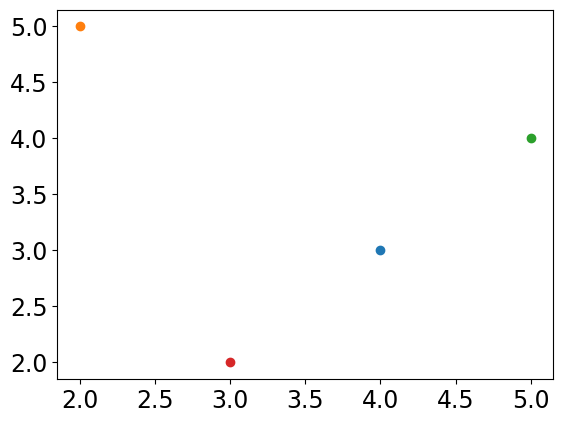

In [47]:
# test latin: if the sample list is less than num, than will fail!
num = 4
X = [2,3,4,5]; Y= [2,3,4,5]; candidate_lists = [X,Y]
samples_t = lhs(2, samples=num)
combinations = []
for sample in samples_t:
    combination = []
    for i, candidate_list in enumerate(candidate_lists):
        index = int(sample[i] * num)
        combination.append(candidate_list[index])
    combinations.append(combination)
print(combinations)
for combination in combinations:
    plt.scatter(combination[0],combination[1])

In [5]:
# early - 2023--6-01
# Scan for all cases - ONLY run once!  - 
# first, we need to define the bounds for all 8 parameters
bounds_Dint = [3e-20,4e-19]
bounds_Li_decay = [4e-7,2.5e-6 ]
bounds_k_LiP = [1e-10, 1e-8]
bounds_LAM_Nep = [1e-9, 3e-7]
bounds_k_Necr = [1e-21, 9e-20]
bounds_elely_res = [0.999, 1.4]
bounds_V_EC  =  [4.8e-5, 6.67e-5]
bounds_R_cont     = [0.0105, 0.02 ]
Bounds = [
    bounds_Dint,   bounds_Li_decay, bounds_k_LiP,
    bounds_LAM_Nep,bounds_k_Necr,   bounds_elely_res,
    bounds_V_EC,bounds_R_cont]
parameter_names = [
    'Negative inner SEI lithium interstitial diffusivity [m2.s-1]', 
    'Dead lithium decay constant [s-1]', 
    'Lithium plating kinetic rate constant [m.s-1]', 
    'Negative electrode LAM constant proportional term [s-1]', 
    'Negative electrode cracking rate', 
    'Initial electrolyte excessive amount ratio', 
    'EC partial molar volume [m3.mol-1]', 
    'Contact resistance [Ohm]'
]


# Usage example:
BasicPath =  os.path.expanduser("~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
Target  = f'/Get_Random_sets/'
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)
Random_1000 = generate_combinations(Bounds, Num_tot=1000)
filename = BasicPath+Target+'Random_1000sets.csv'
save_combinations_to_csv(Random_1000, parameter_names, filename)
print("Combinations saved to 'Random_1000sets.csv' file.")


Combinations saved to 'Random_1000sets.csv' file.


In [38]:
# reload
def load_combinations_from_csv(filename):
    dataframe = pd.read_csv(filename)
    parameter_names = dataframe.columns.tolist()
    combinations = dataframe.values.tolist()
    return parameter_names, combinations

# Usage example:
filename = BasicPath+Target+'200cases_for_SEI_ONLY.csv'
parameter_names, combinations = load_combinations_from_csv(filename)


In [40]:
#Scan_start = 1;    Scan_end = 10; 
Indexs =np.arange(Scan_start-1,Scan_end)
Para_dict_list = []

def load_combinations_from_csv(filename):
    dataframe = pd.read_csv(filename)
    parameter_names = dataframe.columns.tolist()
    combinations = dataframe.values.tolist()
    return parameter_names, combinations

# Usage example:
filename = BasicPath+Target+'200cases_for_SEI_ONLY.csv'
parameter_names, combinations = load_combinations_from_csv(filename)

for index in Indexs:
    para_active = {}
    for parameter_name,para_value in zip(parameter_names,combinations[index] ):
        para_active[parameter_name] = para_value
    para_sum = {**para_active,**para_dict_Same}
    Para_dict_list.append(para_sum)

In [ ]:
Para_dict_list[0]